# Projeto 1 - Ciência dos Dados

Nome: Carlos Simodo

Nome: Luiz Fernando da Silva Borges

Atenção: Serão permitidos grupos de três pessoas, mas com uma rubrica mais exigente. Grupos deste tamanho precisarão fazer um questionário de avaliação de trabalho em equipe

___
# Obtenção dos tweets

## Preparando o ambiente no jupyter:

In [2]:
%%capture

#Instalando o tweepy
!pip install tweepy

In [5]:
import tweepy
import math
import os.path
import pandas as pd
import json
import numpy as np
from random import shuffle

___
## Autenticando no  Twitter

* Conta: ***[Preencha aqui o id da sua conta. Ex: @hoxie_reader ]***

In [14]:
#Dados de autenticação do twitter:

#Coloque aqui o identificador da conta no twitter: @fulano

#leitura do arquivo no formato JSON
with open('auth.pass') as fp:    
    data = json.load(fp)

#Configurando a biblioteca. Não modificar
auth = tweepy.OAuthHandler(data['consumer_key'], data['consumer_secret'])
auth.set_access_token(data['access_token'], data['access_token_secret'])

___
## Etapas para construção da base de dados:

### Escolha de um produto e coleta das mensagens


In [32]:
#Produto escolhido:
produto = 'Lula'

#Quantidade mínima de mensagens capturadas:
n = 3000

#Quantidade mínima de mensagens para a base de treinamento:
t = 668

#Filtro de língua, escolha uma na tabela ISO 639-1.
lang = 'pt'

Capturando os dados do twitter:

In [33]:
#Cria um objeto para a captura
#api = tweepy.API(auth, wait_on_rate_limit=True)

#Inicia a captura, para mais detalhes: ver a documentação do tweepy
i = 1
msgs_crus = []
for msg_crus in tweepy.Cursor(api.search, q=produto, lang=lang, tweet_mode="extended").items():    
    msgs_crus.append(msg_crus.full_text.lower())
    i += 1
    if i > n:
        break


Apaga retweets

In [ ]:
def apaga_rts(tweets_capturados):
    lista = tweets_capturados
    for e in lista:
        if e.startswith('rt'):
            indice = lista.index(e)
            del lista[indice]
        else:
            pass
    return lista

msgs = apaga_rts(msgs_crus)

In [42]:
#Embaralhando as mensagens para reduzir um possível viés temporal de obtenção para a classificação

shuffle(msgs)

print(len(msgs))

1002


In [43]:
msgs = list(set(list(msgs)))

len(msgs)

1002

Uma vez que a API capturou 2000 tweets, decidimos prosseguir com 1002 tweets no total. 


In [44]:
lista_cortada = msgs[:1002]
msgs = lista_cortada

len(msgs)

1002

Dividimos a quantidade de tweets igualmente para cada membro do grupo efetuar a classificação manual dos tweets em: positivo, negativo e irrelevante 

In [6]:
#Verifica se o arquivso não existem para não substituir um conjunto pronto
if not os.path.isfile('./mensagens_1.xlsx') and os.path.isfile('./mensagens_2.xlsx'):
    
    #pega a quantidade de metade das mensagens escolhidas (deve ser par)
    metade_mensagens = int(len(msgs)/2)
    
    #Abre o arquivo para escrita
    writer1 = pd.ExcelWriter("mensagens_1A.xlsx")
    writer2 = pd.ExcelWriter("mensagens_2A.xlsx")
    
    #divide o conjunto de mensagens totais em duas planilhas, pois trata-se de um projeto em dupla
    dft1 = pd.DataFrame({"Tweets": pd.Series(msgs[:metade_mensagens])})
    dft2 = pd.DataFrame({"Tweets": pd.Series(msgs[metade_mensagens:])})
    
    #converte os data frames para arquivos .xlsx
    dft1.to_excel(excel_writer = writer1, index = False)
    writer1.save()
    
    dft2.to_excel(excel_writer = writer2, index = False)
    writer2.save()
    

### Antes da etapa abaixo, os tweets foram classificados manualmente usando a interface de classificação desenvolvida

Reunimos os arquivos com os tweets e suas etiquetas de classificação em um único arquivo Excel

In [7]:
#junta os dois arquivos excel em um unico
df_mensagens_etiquetadas_1 = pd.read_excel('tabela_etiquetada_1.xlsx') 
df_mensagens_etiquetadas_2 = pd.read_excel('tabela_etiquetada_2.xlsx') 

#a coluna foi nomeada manualmente de 'Tweets'
valores1 = df_mensagens_etiquetadas_1[['Tweets','Etiquetas']]
valores2 = df_mensagens_etiquetadas_2[['Tweets','Etiquetas']]

df_tabela_etiquetada = pd.concat([valores1, valores2])
#df_tabela_etiquetada
#print(len(df_tabela_etiquetada['Etiquetas']))

In [8]:
df_tabela_etiquetada.describe()

,Etiquetas
count,1002.000000
mean,2.422156
std,0.745568
min,1.000000
25%,2.000000
50%,3.000000
75%,3.000000
max,3.000000


## Analise dos tweets

Verificamos se existe pelo menos 252 tweets de cada tipo (positivo, negativo e irrelevante)

AxesSubplot(0.125,0.125;0.775x0.755)


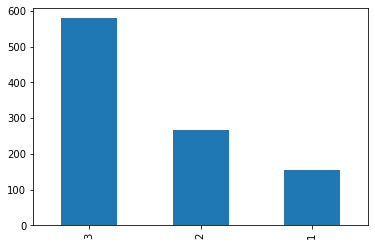

In [9]:
#verifica se o numero de cada tipo etiquetas ultrapassa ou alcanca o minimo necessario
distribuicao = df_tabela_etiquetada['Etiquetas'].value_counts().plot.bar()
print(distribuicao)

## Separacao dos tweets nos dataframes de treino e de teste

In [10]:
def separa_teste_e_treino_igualitario(df):
    #define a divisao
    divisao=1/3
    
    #separa os dataframes em dois novos dataframes
    df_teste, df_treino= np.split(df, [int(divisao*len(df))])

    return df_teste, df_treino

df_teste = separa_teste_e_treino_igualitario(df_tabela_etiquetada)[0]
df_treino = separa_teste_e_treino_igualitario(df_tabela_etiquetada)[1]

## Conta o numero de cada tipo de tweets no dataframe de treino

In [11]:
#conta o numero de vezes que cada etiqueta se repete e coloca numa lista
distribuicao = df_teste['Etiquetas'].value_counts()
lista_dos_numeros_de_cada_tipo_de_etiqueta_teste = distribuicao.to_numpy()
print(lista_dos_numeros_de_cada_tipo_de_etiqueta_teste)

distribuicao = df_treino['Etiquetas'].value_counts()
lista_dos_numeros_de_cada_tipo_de_etiqueta_treino = distribuicao.to_numpy()
print(lista_dos_numeros_de_cada_tipo_de_etiqueta_treino)

print(sum(lista_dos_numeros_de_cada_tipo_de_etiqueta_teste + lista_dos_numeros_de_cada_tipo_de_etiqueta_treino))

[167 103  64]
[412 164  92]
1002


## Vamos filtrar os dois conjuntos de dados para
    
* Remover pontuações
* Remover links
* Tornar todas as letras minísculas 
* Colocar um espaço antes e um depois de cada emoji
* Substituir mais de um espaçamento entre dois elementos por apenas um

In [12]:
import emoji
import re

#Remove as pontuações !-.:?;,%&*_+-\/ e links
def limpa_pontuacao_links(tweet_1):
    
    pontuacoes = '[!-.:?;,%&*_+-\/|]'
    padrao = re.compile(pontuacoes)
    tweet_sem_pontuacoes = re.sub(padrao, "", tweet_1)
    
    tweet_sem_links = re.sub("http[^\s]*", "", tweet_sem_pontuacoes)
    
    tweet_sem_links = tweet_sem_links.replace("\n", " ") ################# COMO TIRAR COM REGEX??!!
    
    return tweet_sem_links

#minha_string = minha_string.replace('\n', '')

#faz com que cada emoji tenha um espaço antes e depois dele
def cerca_emoji(tweet_3):
    lista_str_letras=""
    for letra in tweet_3:
        if letra in emoji.UNICODE_EMOJI:
            lista_str_letras = lista_str_letras + " " + letra + " "
        else:
            lista_str_letras = lista_str_letras + letra

    return lista_str_letras

#faz com que todas as letras sejam minúsculas e com apenas um espaço entre duas palavras
def minusculo_espacos(tweet_3):
    
    tweet_minusculo = tweet_3.lower()
        
    tweet_espacos = re.sub(" +"," ", tweet_minusculo)
    
    return tweet_espacos

#aplica as três funções acima de uma vez
def filtro(tweet):
    tweet = limpa_pontuacao_links(tweet)
    tweet = cerca_emoji(tweet)
    tweet = minusculo_espacos(tweet)
    return tweet


Aplica os filtros citados para a coluna de tweets do dataframe de treino e salva em um novo dataframe filtrado

In [13]:
df_treino_filtrado = df_treino
df_treino_filtrado["Tweets"]  = df_treino_filtrado["Tweets"].apply(filtro)
df_treino_filtrado.head(7)

,Tweets,Etiquetas
334,rt @uolnoticias pt confirma candidatura de ben...,3
335,boa tarde patriotas deus é conservador o diabo...,2
336,@uol vamos seguir a cartilha do lula então sig...,3
337,@nosdaimprensa @teteduche @xicosa leiase a est...,3
338,@prsmalacheia @p0mb4g1ra burrismo mesmo foi qu...,3
339,rt @ptnosenado perseguição repetida lava jato ...,2
340,@ferreiramaromba @raquela38128936 @lulaoficial...,1


Aplica os filtros citados para a coluna de tweets do dataframe de teste e salva em um novo dataframe filtrado

In [14]:
df_teste_filtrado = df_teste
df_teste_filtrado["Tweets"]  = df_teste_filtrado["Tweets"].apply(filtro)
df_teste_filtrado.head(7)


,Tweets,Etiquetas
0,rt @emirsader lula não adianta eleger um presi...,3
1,@macunaimaz @coelho7l @ath1abalba @eutrilheiro...,3
2,@veramagalhaes chama o lula,1
3,amo que a luizianne vai se candidatar a prefei...,2
4,@belgranosouza @sidestranhe @rfmron @fernandoh...,3
5,@nane12958293 @lulemedeiros @lulaoficial vocês...,1
6,@ladyfontenelle são paulo já está quase sem na...,2


## Criando as series de tweets positivos, negativos e irrelevantes de treino

In [15]:
filtro_positivo_treino = df_treino_filtrado["Etiquetas"] == 1
filtro_negativo_treino =  df_treino_filtrado["Etiquetas"] == 2
filtro_irrelevante_treino =  df_treino_filtrado["Etiquetas"] == 3

positivo_treino = df_treino_filtrado.loc[filtro_positivo_treino]
negativo_treino = df_treino_filtrado.loc[filtro_negativo_treino]
irrelevante_treino = df_treino_filtrado.loc[filtro_irrelevante_treino]

serie_positivo_treino = positivo_treino["Tweets"]
serie_negativo_treino = negativo_treino["Tweets"]
serie_irrelevante_treino = irrelevante_treino["Tweets"]
serie_todos_tweets_treino = pd.concat([serie_positivo_treino, serie_negativo_treino, serie_irrelevante_treino])

In [16]:
#debug


## Criando o classificador


Separando as séries de tweets positivos, negativos e irrelantes do conjunto de treino

In [17]:
string_positivo_treino = " ".join(serie_positivo_treino)
serie_positivo_treino = pd.Series(string_positivo_treino.split())

string_negativo_treino = " ".join(serie_negativo_treino)
serie_negativo_treino = pd.Series(string_negativo_treino.split())

string_irrelevante_treino = " ".join(serie_irrelevante_treino)
serie_irrelevante_treino = pd.Series(string_irrelevante_treino.split())


Criando as tabelas de frequências relativas dos tweets positivos, negativos e irrelevantes do conjunto de treino

In [18]:
tabela_relativa_positivo_treino = serie_positivo_treino.value_counts()
tabela_relativa_negativo_treino = serie_negativo_treino.value_counts()
tabela_relativa_irrelevante_treino = serie_irrelevante_treino.value_counts()

Criando o conjunto que vai nos servir como o conjunto de todos os tweets existentes

In [19]:
string_todos_tweets_treino = string_positivo_treino + string_negativo_treino + string_irrelevante_treino

serie_todos_tweets_treino = pd.Series(string_todos_tweets_treino.split())

tabela_relativa_todos_tweets_treino = serie_todos_tweets_treino.value_counts()


### Calculando priors

In [20]:
probP = len(serie_positivo_treino)/len(serie_todos_tweets_treino)
probN = len(serie_negativo_treino)/len(serie_todos_tweets_treino)
probI = len(serie_irrelevante_treino)/len(serie_todos_tweets_treino)

In [21]:
print(probP, probN, probI)
soma = probP+probN+probI
print(soma)

0.1323338525441329 0.25571131879543096 0.6120846313603323
1.0001298026998962


### Calculando termos P(Tweet|Positivo), P(Tweet|Negativo), P(Tweet|Irrelevante) 

In [22]:
def prob_tweet_positivo(tweet_teste_1):
    prob_tweet_positivo = 1            #evita underlow
    for palavra in tweet_teste_1.split():
        prob_palavra_tweet_positivo = tabela_relativa_positivo_treino[palavra]
        prob_tweet_positivo = prob_tweet_positivo * prob_palavra_tweet_positivo
        
    return prob_tweet_positivo

In [23]:
def prob_tweet_negativo(tweet_teste_2):
    prob_tweet_negativo = 1             #evita underlow
    for palavra in tweet_teste_2.split():
        prob_palavra_tweet_negativo = tabela_relativa_negativo_treino[palavra]
        prob_tweet_negativo = prob_tweet_negativo * prob_palavra_tweet_negativo
        
    return prob_tweet_negativo

In [24]:
def prob_tweet_irrelevante(tweet_teste_3):
    prob_tweet_irrelevante = 1             #evita underlow
    for palavra in tweet_teste_3.split():
        prob_palavra_tweet_irrelevante = tabela_relativa_irrelevante_treino[palavra]
        prob_tweet_irrelevante = prob_tweet_irrelevante * prob_palavra_tweet_irrelevante
        
    return prob_tweet_irrelevante

### Calculando os termos P(Positivo|Tweet), P(Negativo|Tweet), P(Irrelavante|Tweet) 

In [25]:
def maior_prob(tweet_4):
    prob_positivo_dado_tweet = probP * prob_tweet_positivo(tweet_4)
    prob_negativo_dado_tweet = probN * prob_tweet_negativo(tweet_4)
    prob_irrelevante_dado_tweet = probI * prob_tweet_irrelevante(tweet_4)
    
    if prob_positivo_dado_tweet > prob_negativo_dado_tweet and prob_positivo_dado_tweet > \
    prob_irrelevante_dado_tweet:
        return 1
    if prob_negativo_dado_tweet > prob_positivo_dado_tweet and  prob_negativo_dado_tweet > \
    prob_irrelevante_dado_tweet:
        return 2
    else:
        return 3
        

tweet = "@uol"

print(maior_prob(tweet))

3


___
### Classificando as mensagens na coragem

Esta etapa é manual. Faça a mesma pelo Excel.

**Importante: Caso classifique um percentual pequeno de tweets relevantes ou de não relevantes, deve voltar a este notebook e coletar mais tweets diferentes do produto escolhido pelo grupo.**